In [1]:
import numpy as np
from numpy import log, exp, zeros, dot, array
import itertools
import pandas as pd
from itertools import product
import timeit
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import warnings

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/james/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [83]:
def log_sum_exp(x):
    
    m = x.max()
    x_s = x - m
    return m + log((exp(x_s)).sum())


def label_seq(l,j):
    '''Creates a list of all posible length l sequences taking values in
       {0,1,...,j-1}. Out put list is of length j^l'''
    
    
    return list(product(list(range(j)), repeat=l))

def find_legit_vals(k,l,n):
    '''Finds the only possible label pairs (i,j) with f_k(i,j,x,t) != 0.
       Will be used to speed up gradient computation.
       l: Number of labels
       n: Size of a nodes feature vector'''
    
    res = []
    k_s = k - n*l
    
    if k_s < 0:  #Means k is in the Unary features
        
        i = k // n
        
        for j in range(l):
            
            res.append((i,j))
            
    else:  #Means k is a Binary feature
        
        f = (k_s // n)
        j = f % l
        i = f // l
        res.append((i,j))  
    
    return res

C_init = np.array([1,1,0])

class CRF(object):
    
    def __init__(self, feature_function, K, L, lamb=1, W = 'none'):
        ''' If our labels belong to space L and our observations belonging to X amd
            then length of our chain is T (call {0,1, ... , T-1} = T') then 
            feature_functions is a vector valued function, f: L^2 x X x T' --> R^K
            i.e. f(i,j,x,t) is a K-d real valued vector and has component functions of the form
            f_k(i,j,x,t) to be specified, think of (i,j) = (y_t, y_t-1). It will have an optional
            keyword argument 'project' which defaults to -1, if a positive integer k,
            it will project onto the k-th component.
            
            K: # of Features
            
            L: Number of labels. Will assume labels have been encoded as integers in {0,...,L-1} 
            
            lamb: L2 regularization constant'''
        
        self.K = K
        self.L = L
        self.Lambda = lamb
        self.f_x = feature_function
        
        if type(W) == str:
            if W == 'none':
                self.W = 0.2 * np.random.randn(K)
                
            if W == 'U':
                self.W = np.zeros(K)
                self.W[0] = 1
            if W == 'B':
                self.W = np.ones(K)
                self.W[1:] = np.random.randn(K-1)
        else:
            self.W = W
            
      
        
    def  log_forward(self, x):
        '''This computes the log(alphas) as in the forward-backward algorithm in order to
           be used for inference tasks later on.
           x is an observation.'''
        
        f = self.f_x
        T = x.shape[0]
        alphas = zeros((T, self.L))
        
        # Initialization
        
        for l in range(self.L):
            
            alphas[0,l] = dot(self.W, f(l,0,x,0))
            
        # Recursion
        
        for t in range(1,T):
            
            for l in range(self.L):
                
                psi = array([dot(self.W, f(l,i,x,t)) for i in range(self.L)])
                
                alphas[t,l] = log_sum_exp(psi + alphas[t-1])
            
        return alphas
    
        
    def log_backward(self, x):
        '''This computes the log(betas) as in the forward-backward algorithm in order to
           be used for inference tasks later on.
           x is an observation.'''
        
        # Initialization
        
        f = self.f_x
        T = x.shape[0]
        betas = np.ones((T, self.L))
      
        # Recursion
        
        for t in range(T-2,-1,-1):
            
            for l in range(self.L):
                
                psi = array([dot(self.W, f(i,l,x,t+1)) for i in range(self.L)])
                
                betas[t][l] = log_sum_exp(psi + betas[t+1])
                
        return betas
    
    
    def log_partition(self, x):
        '''Efficient computation of the log of the partition function Z(x) appearing in CRF model.
           Input an observation and inital label (for forward algorithm) and output is log(Z(x))'''
        
        alphas = self.log_forward(x)
        
        return log_sum_exp(alphas[-1])
    
    
    def MAP(self, x):
        '''Viterbi algortithm for computing the most likely label of a sequence with
           given observation vector x using maximum a posteriori estimation. Using log
           sum version for numeric stability'''
        
        f = self.f_x
        T = x.shape[0]   
        # Initialization
        
        deltas = np.zeros((T, self.L))
        delt_arg = np.zeros((T, self.L))
        
        for l in range(self.L):
            
            deltas[0][l] = dot(self.W, f(l,0,x,0))  # Not sure about this.
            
        # Recursion
        
        for t in range(1,T):
            
            for l in range(self.L):
                
                psi = array([dot(self.W, f(l,i,x,t)) for i in range(self.L)])
                
                deltas[t][l] = (psi + deltas[t-1]).max()
                delt_arg[t][l] = (psi + deltas[t-1]).argmax()
            
        map_lab = np.zeros(T, dtype='i4')
        map_lab[-1] = deltas[-1].argmax()
        
        for t in range(T-2,-1,-1):
            
            map_lab[t] = delt_arg[t+1][map_lab[t+1]]
            
                
        return tuple(map_lab)
        
        
    def marginal(self,i,j,x,t):
        '''Using the forward backward algorithm to compute the marginal p(y_t-1=i,y_t=j|x)'''
        
        f = self.f_x
        alphas = self.log_forward(x)
        betas = self.log_backward(x)
        psi = dot(self.W,f(j,i,x,t))
        psi_b = np.array([dot(self.W,f(k,0,x,0)) for k in range(self.L)])
        log_joint = alphas[t-1][i] + psi + betas[t][j] - log_sum_exp(psi_b + betas[0])
        
        return exp(log_joint)
                       
    def naive_comp(self, x, out='Z'):
        '''Brute force computation of log(Z(x)) or MAP (if out = 'MAP')'''
        
        f = self.f_x
        T = x.shape[0]
        
        # Get List of all possible label sequences
        
        lab_seq = label_seq(T, self.L)
        
        psi = np.zeros(len(lab_seq))
        
        for k in range(len(lab_seq)):
            
            lab = lab_seq[k]
            temp = np.zeros(T)
            temp[0] = dot(self.W, f(lab[0], 0, x, 0))
            
            for t in range(1,T):
                
                temp[t] = dot(self.W, f(lab[t], lab[t-1], x, t))
            
            psi[k] = temp.sum()
        
        arg_m_i = psi.argmax()
        
        return log_sum_exp(psi) if out == 'Z' else lab_seq[arg_m_i]
        
    
    def log_pseudo_marg(self, i, j, k, x, t):
        '''Computes the log probability for pseudolikelihood training.
            i = y_t
            j = y_t-1
            k = y_t+1'''
        
        f = self.f_x
        Z_c = np.zeros(self.L)
        unary_l = [f(l,0,x,t)[0] for l in range(self.L)]
        W = self.W[1:]
        if t == 0:
            
            for l in range(self.L):
                
                Z_c[l] = unary_l[l] + W[26*k + l]
            
            return unary_l[i] + W[26*k + i] - log_sum_exp(Z_c)
        
        elif 0 < t and t < x.shape[0]-1:
            
            for l in range(self.L):
                
                Z_c[l] = unary_l[l] + W[26*l + j] + W[26*k + l]
            
            return unary_l[i] + W[26*k + i] + W[26*i + j] - log_sum_exp(Z_c)
        
        else:
            
            for l in range(self.L):
                
                Z_c[l] =  Z_c[l] = unary_l[l] + W[26*l + j]
            
            return unary_l[i] + W[26*i + j] - log_sum_exp(Z_c)
            
    def grad_pll(self, X, Y):
        
        f = self.f_x
        lb = self.Lambda
        grad = np.zeros(self.K-1)
        
        for n in range(X.shape[0]):
            
            T_n = X[n].shape[0]
            
            for t in range(T_n):
                
                E = np.zeros(self.K-1)
                
                for l in range(self.L):
                    
                    if t == 0:
                        
                        E += np.exp(self.log_pseudo_marg(l,0,Y[n][t+1],X[n],0)) * f(Y[n][t+1],l,X[n],0)[1:]
                        
                    elif 0 < t and t < T_n - 1:
                        
                        E += np.exp(self.log_pseudo_marg(l,Y[n][t-1],Y[n][t+1],X[n],t))*(f(Y[n][t+1],l,X[n],t)[1:] +
                                                  f(l,Y[n][t-1],X[n],t)[1:])
                        
                    else:
                        
                        E += np.exp(self.log_pseudo_marg(l,Y[n][t-1],0,X[n],t)) * f(l,Y[n][t-1],X[n],t)[1:]
                        
                if t == 0:
                    
                    grad += f(Y[n][t+1], Y[n][t],X[n],t)[1:]-E
                    
                elif 0 < t and t < T_n-1:
                    
                    grad += f(Y[n][t+1], Y[n][t],X[n],t)[1:]+f(Y[n][t], Y[n][t-1],X[n],t)[1:]-E
                    
                else: 
                    
                    grad += f(Y[n][t], Y[n][t-1],X[n],t)[1:]-E
                    
        return lb * self.W[1:] - grad
        
    
    
    def gradient(self, X, Y):
        ''' Creates the gradient vector of the log-likelihood. 
            X, Y: Are arrays containing training examples.'''
        
        f = self.f_x
        lamb = self.Lambda
        grad = np.zeros(self.K)
        
        for k in range(self.K):
            
            val_pair = find_legit_vals(k, self.L, X.shape[-1])
            first_term = np.zeros((X.shape[0],T))
            
            for n in range(X.shape[0]):
                
                T = X[n].shape[0]
                for t in range(T):
                    
                    first_term[n][t] = f(Y[n][t], Y[n][t-1], X[n], t, project=k)
            
            sec_term = np.zeros((X.shape[0],self.T))
            
            for n in range(X.shape[0]):
                
                for t in range(T):
                    
                    marginals = np.zeros(len(val_pair))
                        
                    for j in range(len(val_pair)):
                        
                        y, y_p = val_pair[j]
                        marginals[j] = (f(y, y_p, X[n], t, project=k) * 
                                        self.marginal(y, y_p, X[n], t))
                    
                    sec_term[n][t] = marginals.sum()
                    
            grad[k] = (first_term + sec_term).sum() - self.W[k] * lamb
            print(k)
        return grad
    
    
    def gradient_f(self, X, Y):
        
        f = self.f_x
        lamb = self.Lambda
        grad_f = np.zeros(self.K)
        lab_pairs = label_seq(2,self.L)
        
        for n in range(X.shape[0]):
            
            T = X[n].shape[0]
            grad = np.zeros(self.K)
            x, y = X[n], Y[n]
            
            for t in range(T):
            
                grad = grad + f(y[t],y[t-1],x,t)
        
            for pair in lab_pairs:
                print(pair)
                y, y_p = pair[0], pair[1]
                grad_temp = np.zeros(self.K)
            
                for t in range(T):
                
                    marg = self.marginal(y,y_p,x,t)
                    grad_temp = grad_temp + (marg*f(y,y_p,x,t))
        
                grad = grad - grad_temp
            
            grad_f = grad_f + grad
    
        return lamb * self.W  - grad_f
    
    def reg_neg_ll(self, X, Y):
        
        f = self.f_x
        res = 0
        for n in range(X.shape[0]):
            
            T = X[n].shape[0]
            s = 0
            
            for t in range(T):
            
                s += np.dot(self.W,f(Y[n][t],Y[n][t-1],X[n],t))
            
            res += self.log_partition(X[n]) - s
         
        return res

In [3]:
data = pd.read_csv('/home/james/anaconda3/data/HW/OCR/letter/data.tsv', sep='\t', header=None)

In [4]:
data[:15]

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1,o,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,2,m,3,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,3,m,4,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,4,a,5,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,n,6,1,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5,6,d,7,1,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
6,7,i,8,1,7,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,NaN
7,8,n,9,1,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
8,9,g,-1,1,9,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,NaN
9,10,o,11,2,1,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [5]:
im = data.ix[11004].as_matrix()[6:-1]
data_m = data.as_matrix()

In [6]:
im = np.asarray(im.reshape((16,8)),dtype='i4')

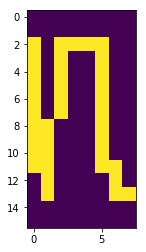

In [21]:
plt.imshow(np.int32(X_tr[-2][0].reshape((16,8))))

In [7]:
word_data = []
label_data = []

start = 0

for k in range(1,52152):
    
    if data_m[k,4] < data_m[k-1,4]:
        
        word_data.append(data_m[start:k,6:-1])
        label_data.append(data_m[start:k,1])
        start = k 

In [8]:
X_n, y_n = np.zeros((52152,128)), np.zeros((52152,26), dtype='int32')

for k in range(52152):
    X_n[k] = data_m[k,6:-1]
    y_n[k,ord(str(data_m[k,1]))-97] = 1

In [9]:
wd_d = np.array(word_data)
wd_d.shape

(6876,)

In [10]:
X_vl = wd_d

In [13]:
y_vl = []

for k in label_data:
    
    y_vl.append(encode(k))

y_vl = np.array(y_vl)

In [14]:
y_vl[-1]

array([13,  2, 14, 13, 18,  4, 16, 20,  4, 13, 19,  8,  0, 11], dtype=int32)

In [15]:
label_data[-1]

array(['n', 'c', 'o', 'n', 's', 'e', 'q', 'u', 'e', 'n', 't', 'i', 'a', 'l'], dtype=object)

In [16]:
y_n[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

In [12]:
def encode(a):
    res = np.zeros(len(a), dtype='i4')
    for k in range(len(a)):
        res[k] = ord(a[k]) - 97
    return res

In [63]:
def feat_func(i,j,x,t):
    
    N = 128                     # Twice the length of data vector
    L = 26                         # number of labels
    T = 14                          # length of sequence
    
    
    binary_chi = np.zeros(L**2)
    unary_chi = unary_model1.predict(x[t].reshape((1,128)))[0,i]
    
    if t > 0:
    
        binary_chi[(L*i+j)] = 1
        
    
    
    output = np.zeros(1 + L**2)
    output[0] = unary_chi
    output[1:] = binary_chi
    
    return output

In [18]:
dims = np.arange(6876)
np.random.shuffle(dims)

X_tr, y_tr = X_vl[dims[:-676]], y_vl[dims[:-676]]
X_ts, y_ts = X_vl[dims[-676:]], y_vl[dims[-676:]]

In [19]:
X_tr.shape

(6200,)

In [73]:
crf = CRF(feat_func, 26**2+1,26,lamb=3, W='B')

In [66]:
crf.log_pseudo_marg(1,1,1,X_tr[0],2)

-10.358306067904895

In [75]:
#g = crf.grad_pll(X_tr[:16],y_tr[:16])

g[:35]

array([  3.0170433 ,  13.98363357,  15.98735387,  15.6663122 ,
         7.11589492,  11.20540012,  14.20762575,   6.45963354,
        17.46031956,   6.73833861,  12.29407045,  18.03951835,
        15.00426585,  23.58519753,   2.89297034,  14.3285808 ,
         3.21000409,  19.3483152 ,  18.82247743,  20.01563854,
        13.19381771,  14.16106772,  10.86086251,   8.66131703,
        15.41231757,   6.16130034,  13.55061437,   6.04598046,
        -0.92999654,  -1.13987186,  16.59907135,  -9.09000072,
        -9.96000036,  -4.64978003,  12.15773358])

In [100]:
# Adam stochastic mini-batch gradient descent on the (negative) pseudo-log-liklelihood.

from scipy.spatial.distance import hamming 

crf = CRF(feat_func,26**2+1,26, 1e-12, W=best_W)
crf_u = CRF(feat_func,26**2+1,26, 1, W='U')
alpha = 0.01
B1, B2 = 0.9, 0.999
eps = 1e-7
m, v = np.zeros(crf.K-1), np.zeros(crf.K-1)
#best_W = np.zeros(crf.K)
#best_acc = 0
num_epochs = 2
batch_size = 64
epoch = 1

acc_t1, acc_tu = np.zeros(30), np.zeros(30)

for n in range(30):
    acc_t1[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
    acc_tu[n] = 1 - hamming(crf_u.MAP(X_ts[n]), y_ts[n])
    
print('Initial accuracy score: ',100* acc_t1.mean(), '%.')
print('Compared to Unary Only: ', 100* acc_tu.mean(), '%.')

while epoch <= num_epochs:
    
    min_batch = np.arange(X_tr.shape[0])
    np.random.shuffle(min_batch)
    
    for k in range(0, X_tr.shape[0],batch_size):
        
        X_b, y_b = X_tr[min_batch[k:k+batch_size]],y_tr[min_batch[k:k+batch_size]]
        t = (X_tr.shape[0]//batch_size)*(epoch-1) + (k // batch_size) + 1
        g = crf.grad_pll(X_b, y_b)
        m = B1 * m + (1-B1) * g
        v = B2 * v + np.square(np.sqrt(1-B2) * g)
        m_b = m / (1 - B1**t)
        v_b = v / (1 - B2**t)
        crf.W[1:] = crf.W[1:] - (alpha * m_b) / (np.sqrt(v_b) + eps)
        
        if (k // batch_size) % 5 == 0:
            
            acc_test = np.zeros(30)
            
            for n in range(30):
                acc_test[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
            print('Epoch/Iteration: ', epoch, '/', t-1, '. Current Average Test Hamming Accuracy: ',
                  100* acc_test.mean(), '%.')
            
            if best_acc <= acc_test.mean():
                best_acc = acc_test.mean()
                best_W = crf.W
        
    epoch += 1

    
acc_f, acc_fu = np.zeros(X_ts.shape[0]), np.zeros(X_ts.shape[0])

for n in range(X_ts.shape[0]):
    acc_f[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
    acc_fu[n] = 1 - hamming(crf_u.MAP(X_ts[n]), y_ts[n])

Initial accuracy score:  95.2857142857 %.
Compared to Unary Only:  89.4004329004 %.
Epoch/Iteration:  1 / 0 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 5 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 10 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 15 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 20 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 25 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 30 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 35 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 40 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 45 . Current Average Test Hamming Accuracy:  95.2857142857 %.
Epoch/Iteration:  1 / 50 . Current Average Test Hamming Accuracy:  95.28571428

KeyboardInterrupt: 

In [91]:
best_acc

0.96121693121693119

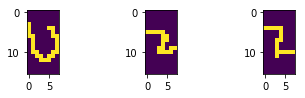

In [188]:
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(np.int32(X_tr[-2][0].reshape((16,8))))
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(np.int32(X_tr[-2][1].reshape((16,8))))
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(np.int32(X_tr[-2][2].reshape((16,8))))



In [174]:
print(''.join([chr(let + 97) for let in crf.MAP(X_tr[-2])]))

uzz


In [175]:
print(''.join([chr(let + 97) for let in y_tr[-2]]))

uzz


In [ ]:
# Simultaneuos Pertubation Stochastic Approximation
from scipy.stats import bernoulli
from scipy.spatial.distance import hamming 

alpha, gamma = 0.602, 0.101
A, c, a = 1000, 0.0001, 0.0001

crf = CRF(feat_func, 2+26**2, 26, C=[1.04812081,0.83590713, 0.36205899], W="B")

epoch = 0
batch_size = 32

acc_test = np.zeros(30)
for n in range(30):
    acc_test[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
            
print('Average test Hamming accuracy with only trained unary features: ',
        100* acc_test.mean(), '%.')
print(crf.C)         

while epoch < 2:
    
    dims = np.arange(X_tr.shape[0])
    np.random.shuffle(dims)
    
    for b in range(0,6200, batch_size):
        
        X_b, y_b = X_tr[dims[b:b+batch_size]],y_tr[dims[b:b+batch_size]]
        k = (6200//batch_size)*epoch + (b // batch_size)
        alpha_k = a / (A + k +1)**alpha
        c_k = c / (k + 1)**gamma
        del_k = 2* c_k * bernoulli.rvs(0.5,size=3) - c_k
        crf_p = CRF(feat_func, 2+26**2, 26, crf.C + del_k ,'B')
        crf_m = CRF(feat_func, 2+26**2, 26, crf.C - del_k, 'B')
    
        diff = (crf_p.reg_neg_ll(X_b,y_b) - crf_m.reg_neg_ll(X_b,y_b)) / 2 * batch_size
        C = crf.C - (alpha_k * diff) * (1 / del_k)
        crf = CRF(feat_func, 2+26**2, 26, C, "B")
        print(diff)
        print(crf.C)     # 12 = (a,m): 9 = (a,j): 30 = (b,e): 51 = (b,z)
        if k  % 10 == 0:
            
            acc_test = np.zeros(30)
            
            for n in range(30):
                acc_test[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
            
            print('Iteration: ',k, '. Current Average Test Hamming Accuracy: ',
                100* acc_test.mean(), '%.')
        
        
    epoch += 1

acc_test = np.zeros(30)
            
for n in range(30):
    acc_test[n] = 1 - hamming(crf.MAP(X_ts[n]), y_ts[n])
            
print('Iteration: ',k, '. Current Average Test Hamming Accuracy: ',
        100* acc_test.mean(), '%.')
        

Average test Hamming accuracy with only trained unary features:  94.7852332852 %.
[1.04812081, 0.83590713, 0.36205899]
-0.396999118882
[ 1.04191886  0.84210908  0.35585704]
Iteration:  0 . Current Average Test Hamming Accuracy:  94.7852332852 %.
-0.0766653254679
[ 1.04320261  0.84339283  0.35457329]
0.0958462803525
[ 1.04153159  0.84506385  0.35290227]
0.0728119366489
[ 1.04022552  0.84636992  0.3515962 ]
-0.241988192441
[ 1.03578855  0.84193295  0.34715923]
0.323152990521
[ 1.02975689  0.84796462  0.34112756]
0.252519455048
[ 1.03454127  0.85274901  0.33634318]
-0.217801923849
[ 1.03872141  0.85692914  0.33216304]
-0.0754120718506
[ 1.03725762  0.85546536  0.33069926]
-0.0951065165789
[ 1.03912232  0.85733006  0.32883456]
0.105234027837
[ 1.03704034  0.85524808  0.32675258]
Iteration:  10 . Current Average Test Hamming Accuracy:  94.309042809 %.
-0.0862478016505
[ 1.03876073  0.85696847  0.32503219]
0.152279466811
[ 1.04182109  0.85390811  0.32197183]
-0.0888929890331
[ 1.04361993  0.

0.0400960868254
[ 1.06235722  0.79567865  0.10347187]
0.0391653406969
[ 1.06142662  0.79660925  0.10254126]
-0.114720505079
[ 1.05870014  0.79933573  0.09981479]
0.0685425024742
[ 1.0603295   0.79770637  0.09818543]
0.0921683007566
[ 1.06252095  0.79551492  0.09599398]
0.0425435434281
[ 1.0615092   0.79450317  0.09498223]
0.146645606456
[ 1.05802101  0.79101499  0.09149405]
0.0330932889335
[ 1.05880834  0.79022765  0.09228138]
-0.0202910447633
[ 1.05929119  0.78974481  0.09276422]
0.0217363176851
[ 1.05980852  0.78922748  0.09224689]
Iteration:  140 . Current Average Test Hamming Accuracy:  93.6106301106 %.
0.0722051742382
[ 1.05808969  0.79094631  0.09052805]
0.105066828591
[ 1.05558813  0.78844475  0.08802649]
0.219964046057
[ 1.05035003  0.78320665  0.08278839]
-0.137101977793
[ 1.05361546  0.77994122  0.07952296]
-0.01991724347
[ 1.053141    0.77946676  0.0790485 ]
0.0691352310055
[ 1.05149382  0.77781958  0.07740132]
0.00242940873426
[ 1.05143593  0.77776169  0.07745921]
0.0173896

0.123715557557
[ 1.00228842  0.73321612  0.01947607]
-0.00259392353439
[ 1.00235025  0.73315429  0.01941423]
-0.0698039922776
[ 1.00068635  0.73149038  0.01775033]
-0.0687565843358
[ 0.99904757  0.7298516   0.01611155]
0.0476961867396
[ 0.99791087  0.7287149   0.01724825]
0.0519895361008
[ 0.99667196  0.727476    0.01600935]
0.00151007790964
[ 0.99670794  0.72751198  0.01604533]
-0.0739809846715
[ 0.99494534  0.72574937  0.01780793]
Iteration:  270 . Current Average Test Hamming Accuracy:  93.9136604137 %.
0.0109282081349
[ 0.994685    0.72600971  0.01806827]
0.0163939742952
[ 0.99507551  0.72640022  0.01845878]
0.0233643572487
[ 0.99451902  0.72695671  0.01901527]
-0.0363920638316
[ 0.99365234  0.7278234   0.01988195]
0.0714356487833
[ 0.99195126  0.72612232  0.01818087]
0.0085065072908
[ 0.99174872  0.72632486  0.01797833]
0.00292690927472
[ 0.9918184   0.72639454  0.01790865]
0.0479209782427
[ 0.99067764  0.72525378  0.01904941]
0.000289789705789
[ 0.99067074  0.72526067  0.01905631

0.0214287363585
[ 0.96220389  0.6907552  -0.00325554]
0.0431392622422
[ 0.96321319  0.6897459  -0.00426483]
-0.0695356229726
[ 0.96483977  0.68811932 -0.00263825]
-0.0503781917097
[ 0.96601802  0.68694107 -0.00381649]
-0.0405757147074
[ 0.9650692   0.68788989 -0.00476531]
0.0859091032364
[ 0.96306067  0.68588136 -0.00677384]
-0.00986523372558
[ 0.96329128  0.68611196 -0.00654323]
Iteration:  400 . Current Average Test Hamming Accuracy:  94.284030784 %.
-0.0397785469178
[ 0.9623616   0.68518228 -0.00747291]
-0.0466814016064
[ 0.96127078  0.68409147 -0.0063821 ]
0.0154053079486
[ 0.9616307   0.68373155 -0.00674201]
0.0439459467713
[ 0.96265722  0.68270503 -0.00776854]
0.0275561718875
[ 0.96201366  0.68334859 -0.00712497]
0.0230865519324
[ 0.96147458  0.68280951 -0.00658589]
0.0213690486271
[ 0.96197346  0.68231062 -0.00708478]
0.0760697180476
[ 0.96374909  0.680535   -0.00886041]
-0.00856590181877
[ 0.963949    0.68073491 -0.00906032]
-0.0474598139107
[ 0.96284159  0.6796275  -0.0079529 

0.0143093024017
[ 0.94610466  0.64541735 -0.00522466]
0.00509730940223
[ 0.94622091  0.6453011  -0.00534091]
-0.0360145562955
[ 0.9470421   0.6444799  -0.00616211]
0.000260248200675
[ 0.94703617  0.64447397 -0.00615617]
Iteration:  530 . Current Average Test Hamming Accuracy:  94.284030784 %.
-0.0573747098556
[ 0.94572846  0.64578168 -0.00484846]
-0.11882023728
[ 0.9430208   0.64307403 -0.00755612]
0.012861146916
[ 0.94331382  0.64278101 -0.0072631 ]
0.0900517327495
[ 0.94126257  0.64072976 -0.00931435]
0.0024355251112
[ 0.94131804  0.64067429 -0.00925888]
-0.0142767929556
[ 0.94164311  0.64099936 -0.00893381]
0.0250506040278
[ 0.94107284  0.64156963 -0.00836354]
0.000837939637677
[ 0.94109191  0.64155056 -0.00834447]
-0.0648315455971
[ 0.94256718  0.64007529 -0.0068692 ]
0.0579323398953
[ 0.94388518  0.6413933  -0.00818721]
Iteration:  540 . Current Average Test Hamming Accuracy:  94.284030784 %.
0.00155981570083
[ 0.9438497   0.64142878 -0.00815173]
0.0137922782472
[ 0.94353605  0.64

0.0390459045223
[ 0.93014759  0.59600874 -0.00182753]
-0.0165178313412
[ 0.93051445  0.5963756  -0.00146068]
-0.0549146090394
[ 0.92929507  0.59515622 -0.00268006]
-0.0488598996675
[ 0.93037977  0.59407151 -0.00376476]
0.0272491934787
[ 0.92977496  0.59346669 -0.00436958]
0.0125857829728
[ 0.92949567  0.5931874  -0.00464887]
Iteration:  660 . Current Average Test Hamming Accuracy:  94.284030784 %.
-0.0234936102229
[ 0.93001691  0.59266616 -0.00517011]
0.00199445716476
[ 0.93006115  0.5927104  -0.00521435]
-0.0460008364114
[ 0.93108131  0.59373057 -0.00623452]
-0.0054746907158
[ 0.93095992  0.59385196 -0.0063559 ]
0.0283156027486
[ 0.93033223  0.59447965 -0.0069836 ]
0.0148752219138
[ 0.93066191  0.59480933 -0.00731328]
-0.0886659142166
[ 0.92869721  0.59284463 -0.00927798]
-0.0461362054281
[ 0.9297193   0.59386672 -0.00825589]
0.0132422171093
[ 0.93001261  0.59416003 -0.00854919]
-0.0121564234979
[ 0.92974341  0.59389083 -0.00827999]
Iteration:  670 . Current Average Test Hamming Accur

0.0327160290901
[ 0.92596895  0.5808641  -0.01275004]
0.0402751374178
[ 0.92683905  0.579994   -0.01187994]
-0.00475436902946
[ 0.92673636  0.57989131 -0.01177725]
0.0221906235078
[ 0.92625715  0.58037051 -0.01225645]
Iteration:  790 . Current Average Test Hamming Accuracy:  94.284030784 %.
-0.0420363288832
[ 0.92534957  0.58127809 -0.01134887]
-0.0728535789789
[ 0.92692218  0.57970548 -0.00977626]
-0.0101982249143
[ 0.92714228  0.57948539 -0.00955616]
0.0313598544417
[ 0.92781893  0.57880874 -0.00887951]
-0.0504347224234
[ 0.92673092  0.57989674 -0.00996752]
-0.0560674293099
[ 0.92794019  0.57868748 -0.01117678]


In [22]:
letts0 = '7.38 11.5 12.2 12.1 9.25 10.6 11.6 9.03 12.4 9.03 11.0 13.1 11.9 13.8 7.79 11.4 7.95 13.3 13.0 13.5 11.1 11.6 10.5 9.64 12.0 9.23'
letts1 = '11.4 9.00 6.57 6.50 12.4 3.85 3.56 5.33 10.9 8.14 3.56 11.5 6.93 5.61 11.5 5.25 0.1 10.6 10.2 8.52 11.3 7.05 6.57 0.1 11.4 2.71'
letts2 = '12.4 4.08 10.4 5.76 12.7 3.00 .69 12.5 11.7 1.10 11.4 11.1 4.89 4.90 12.8 3.76 7.87 11.2 9.47 12.1 11.2 1.95 3.00 .69 9.93 5.82'
letts3 = '11.6 7.33 7.73 10.1 12.8 7.46 9.83 7.55 12.2 7.54 5.46 9.76 9.44 9.16 11.4 6.09 6.83 10.7 11.0 7.30 11.0 9.31 8.73 .00 9.98 5.09'
letts4 = '12.8 10.2 12.4 13.3 12.2 11.2 11.0 9.36 11.3 7.58 9.97 12.4 12.0 13.4 10.6 11.4 9.52 13.9 13.4 12.3 9.23 11.6 11.5 11.3 11.4 8.43'
letts5 = '11.1 4.32 4.78 3.50 11.5 11.3 6.02 3.64 11.9 4.23 5.42 10.1 6.27 5.31 12.4 3.26 0.1 11.5 8.16 10.8 10.5 3.81 4.91 1.39 8.18 2.56'
letts6 = '11.4 5.36 3.58 6.81 12.2 6.20 9.57 11.7 11.0 3.09 4.68 9.99 7.66 10.4 11.0 5.28 1.95 11.3 10.3 9.35 10.6 2.94 5.96 2.08 9.12 3.64'
letts7 = '13.1 8.20 6.35 7.84 14.1 6.60 5.24 6.21 12.6 3.50 5.91 9.00 8.58 9.71 12.4 5.91 5.12 10.6 9.32 11.2 10.2 5.18 8.07 0.1 9.54 2.64'
letts8 = '11.9 10.4 12.8 12.4 12.1 11.1 11.8 6.54 7.10 7.21 10.4 12.5 11.8 14.0 12.7 10.5 8.09 11.9 13.1 13.1 8.71 11.7 6.71 9.25 6.69 10.2'
letts9 = '8.52 1.61 3.43 3.56 9.39 2.08 0.1 1.10 7.24 2.30 3.76 2.40 3.93 3.37 10.0 1.61 0.1 1.39 2.30 2.56 10.1 .69 0.1 0.1 1.39 1.79'
letts10 = '9.21 6.78 4.55 6.64 11.9 6.73 6.35 7.68 11.0 3.85 6.42 9.22 6.53 9.80 8.42 6.30 0.1 8.04 10.5 6.95 7.46 5.42 7.05 .00 8.70 2.56'
letts11 = '12.5 8.60 8.44 11.9 12.9 10.0 7.95 7.18 12.7 4.22 9.54 12.7 9.68 7.78 12.0 9.50 3.43 8.53 11.3 10.9 10.9 9.58 8.49 3.40 12.1 6.25'
letts12 = '12.3 10.7 5.82 5.65 12.8 7.59 4.80 5.64 12.0 3.56 4.30 7.21 10.8 7.95 12.0 11.8 1.39 5.81 10.6 5.84 10.7 4.43 4.88 0.1 9.84 2.89'
letts13 = '12.0 8.42 12.2 13.3 12.8 10.2 13.2 9.07 12.1 8.40 10.5 10.1 9.81 10.9 12.1 7.93 7.36 8.38 12.4 13.1 10.7 10.3 8.30 7.55 11.1 7.75'
letts14 = '10.5 10.6 11.2 11.3 9.82 13.0 10.6 9.43 10.8 8.47 10.6 12.1 12.6 13.6 11.7 11.7 6.27 13.4 11.9 12.2 12.9 11.5 12.0 8.62 9.85 8.30'
letts15 = '12.0 6.81 5.74 5.81 12.3 6.47 7.80 10.4 11.0 4.91 6.47 11.8 8.67 5.60 12.0 11.1 2.08 12.2 10.2 10.4 10.9 1.10 5.85 .00 8.97 3.58'
letts16 = '3.30 1.95 0.1 .00 .69 .69 .00 0.1 6.64 0.1 0.1 1.10 0.1 .00 .00 0.1 1.10 0.1 1.10 1.95 10.9 1.79 .69 0.1 0.1 0.1'
letts17 = '12.8 9.63 11.2 11.6 13.7 9.61 11.0 8.83 12.7 5.58 11.4 10.8 11.3 11.5 12.8 10.1 6.18 11.0 12.5 12.2 11.0 11.0 8.79 5.47 11.6 6.92'
letts18 = '12.1 8.59 11.1 9.10 12.9 8.62 6.66 12.0 12.5 4.16 10.2 10.4 10.1 9.18 12.0 11.3 8.25 8.72 12.2 13.2 11.7 6.44 9.15 .00 9.75 5.97'
letts19 = '12.5 8.43 9.81 7.32 13.3 8.08 7.71 14.2 13.2 4.17 6.14 10.7 9.83 8.95 13.2 7.33 1.95 12.2 12.2 11.4 11.4 6.49 10.5 2.83 11.5 8.49'
letts20 = '10.9 10.8 11.3 10.9 11.2 9.19 11.1 6.29 10.8 5.98 8.08 11.9 11.0 12.1 8.53 11.2 5.73 12.3 12.3 12.4 5.42 7.31 6.43 7.56 8.94 7.43'
letts21 = '10.8 .00 6.05 4.20 12.9 .00 4.52 1.39 12.0 .69 3.18 5.15 2.40 5.34 10.4 0.1 0.1 6.23 6.43 3.71 6.76 4.74 0.1 0.1 8.11 1.10'
letts22 = '12.1 6.89 6.09 7.88 11.8 6.22 3.71 12.0 12.1 0.1 7.07 8.85 7.31 10.7 11.7 5.53 1.95 9.53 10.0 7.87 4.69 .69 2.94 .00 8.43 2.20'
letts23 = '9.11 3.78 9.11 .00 9.61 5.59 1.10 7.76 9.11 0.1 0.1 5.06 4.39 2.94 7.47 10.3 4.76 1.39 4.55 9.75 7.96 4.62 6.11 5.06 6.00 .00'
letts24 = '9.16 8.22 8.48 7.77 11.4 6.35 6.34 6.24 9.92 3.09 5.96 9.07 9.49 9.11 10.6 8.63 1.61 8.97 10.7 8.86 6.57 5.64 8.04 4.42 3.43 6.56'
letts25 = '9.41 5.86 3.69 4.73 10.1 2.56 5.00 6.32 8.93 .69 5.29 6.95 6.00 4.67 8.13 4.98 3.14 4.75 4.98 4.84 6.85 4.84 5.21 0.1 7.23 8.10'

In [23]:
let_list = [letts0, letts1, letts2, letts3, letts4, letts5, letts6, letts7, letts8, letts9,
            letts10, letts11, letts12, letts13, letts14, letts15, letts16, letts17,
            letts18, letts19, letts20, letts21, letts22, letts21, letts22, letts23,
            letts24, letts25]

W_t = np.zeros(26**2)
for i in range(26):
    for j in range(26):
        W_t[26*i+j] = np.exp(np.float32(let_list[i].split(sep=' ')[j]))

In [24]:
for k in let_list[0].split(sep=' '):
    print(np.exp(np.float32(k)))

1603.59
98715.8
198789.0
179872.0
10404.6
40134.9
109098.0
8349.86
242802.0
8349.86
59874.1
488943.0
147267.0
984609.0
2416.32
89321.7
2835.57
597196.0
442413.0
729416.0
66171.2
109098.0
36315.5
15367.3
162755.0
10198.5


In [25]:
#W_t = W_t / W_t.sum()
W_t

array([  3.24160809e-05,   1.99550918e-03,   4.01846107e-03,
         3.63605622e-03,   2.10325109e-04,   8.11313753e-04,
         2.20537956e-03,   1.68789815e-04,   4.90815872e-03,
         1.68789815e-04,   1.21033745e-03,   9.88382504e-03,
         2.97694854e-03,   1.99035762e-02,   4.88451171e-05,
         1.80561060e-03,   5.73202708e-05,   1.20721295e-02,
         8.94325174e-03,   1.47449290e-02,   1.33763032e-03,
         2.20537956e-03,   7.34106808e-04,   3.10646254e-04,
         3.29003846e-03,   2.06160310e-04,   1.80561060e-03,
         1.63801365e-04,   1.44205563e-05,   1.34456353e-05,
         4.90815872e-03,   9.49950285e-07,   7.10813268e-07,
         4.17308020e-06,   1.09515822e-03,   6.93145481e-05,
         7.10813268e-07,   1.99550918e-03,   2.06693990e-05,
         5.52152825e-06,   1.99550918e-03,   3.85223886e-06,
         2.23406932e-08,   8.11313753e-04,   5.43839591e-04,
         1.01357612e-04,   1.63378507e-03,   2.33046924e-05,
         1.44205563e-05,

In [26]:
inp = Input((128,), batch_shape=(128,128))

out1 = Dense(256, activation='relu')(inp)
out1 = Dense(26, activation='softmax', bias=False)(out1) 

unary_model = Model(inp,out1)

In [27]:
unary_model.layers[2].get_weights()[0].shape

(256, 26)

In [28]:
from keras.optimizers import adam

sgd = adam(0.001,epsilon=1e-7)

unary_model.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
unary_model.fit(X_n,y_n,batch_size=128,validation_split=0.10,verbose=2, nb_epoch=20)

Train on 46936 samples, validate on 5216 samples
Epoch 1/20
0s - loss: 1.3034 - acc: 0.6475 - val_loss: 0.9553 - val_acc: 0.7406
Epoch 2/20
0s - loss: 0.7520 - acc: 0.7925 - val_loss: 0.7635 - val_acc: 0.7916
Epoch 3/20
0s - loss: 0.6015 - acc: 0.8325 - val_loss: 0.6616 - val_acc: 0.8229
Epoch 4/20
0s - loss: 0.5137 - acc: 0.8554 - val_loss: 0.5828 - val_acc: 0.8395
Epoch 5/20
0s - loss: 0.4530 - acc: 0.8692 - val_loss: 0.5315 - val_acc: 0.8482
Epoch 6/20
0s - loss: 0.4098 - acc: 0.8821 - val_loss: 0.5046 - val_acc: 0.8593
Epoch 7/20
0s - loss: 0.3750 - acc: 0.8910 - val_loss: 0.4845 - val_acc: 0.8625
Epoch 8/20
0s - loss: 0.3481 - acc: 0.8976 - val_loss: 0.4757 - val_acc: 0.8666
Epoch 9/20
0s - loss: 0.3240 - acc: 0.9049 - val_loss: 0.4596 - val_acc: 0.8719
Epoch 10/20
0s - loss: 0.3033 - acc: 0.9113 - val_loss: 0.4575 - val_acc: 0.8712
Epoch 11/20
0s - loss: 0.2849 - acc: 0.9158 - val_loss: 0.4569 - val_acc: 0.8719
Epoch 12/20
0s - loss: 0.2693 - acc: 0.9197 - val_loss: 0.4556 - val_

In [30]:
inp = Input((128,), (1,128))

out1 = Dense(256, activation='relu',
             weights=unary_model.layers[1].get_weights())(inp)
out1 = Dense(26, activation='linear', bias=False,
             weights = unary_model.layers[2].get_weights())(out1) 

unary_model1 = Model(inp,out1)

In [31]:
unary_model1.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


unary_model1.predict(X_n[0].reshape(1,128))

array([[  0.34048787,  -3.9013896 ,  -1.22336733,  -2.52211809,
         -4.38753939, -12.0569582 ,  -3.11565065, -11.06820774,
        -13.33045006,  -9.76701736,  -8.97757053,  -8.02042866,
         -9.29939079,  -2.44977832,   5.64803791, -10.67316437,
         -5.57821941,  -6.02261019,  -7.73568821,  -9.66280365,
         -3.92789459,  -9.8085146 , -14.479105  , -15.86546421,
         -4.8299408 , -10.92585754]], dtype=float32)

In [135]:
np.argmax(y_n[0])

14

In [27]:
unary_model1.predict(X_n[0].reshape(1,128))[0,0]

0.34048787

In [29]:
y_n[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

In [216]:
probs = {}
for x in y_tr:
    for k in range(len(x)-1):
        if (x[k],x[k+1]) in probs:
            probs[(x[k],x[k+1])] += 1
        else:
            probs[(x[k],x[k+1])] = 1

In [69]:
bin_w = np.zeros(26**2)
bin_w[0] = 1

for k in range(1,26**2):
    bin_w[k] = 0.5 + np.log(W_t[k]) - np.log(W_t[0])

In [77]:
bin_w  = bin_w / 10

In [81]:
def soft_max(y):
    num = np.exp(dot(bin_w,y))

0.0014755393602516324

In [115]:
'''crf_u = CRF(feat_func, 1+26**2, 26,1, W='U')
crf_b = CRF(feat_func, 1+26**2, 26, 1,best_W)

acc_test1, acc_test2 = np.zeros(y_ts.shape[0]),np.zeros(y_ts.shape[0])
            
for n in range(y_ts.shape[0]):
    acc_test1[n] = 1 - hamming(crf_u.MAP(X_ts[n]), y_ts[n])
    acc_test2[n] = 1 - hamming(crf_b.MAP(X_ts[n]), y_ts[n])'''   
    
print('Unary features only vs unary and binary model:')
print('Unary only average Hamming loss: ', 100*acc_test1.mean(), ' %')
print('Unary only complete percent correct:',
      100*acc_test1[acc_test1 == 1].sum() / y_ts.shape[0], ' %')
print('.................................................')
print('Unary and binary average Hamming loss: ', 100*acc_test2.mean(), ' %')
print('Unary and binary complete percent correct:',
      100*acc_test2[acc_test2 == 1].sum() / y_ts.shape[0], ' %')

Unary features only vs unary and binary model:
Unary only average Hamming loss:  95.5184267573  %
Unary only complete percent correct: 73.8165680473  %
.................................................
Unary and binary average Hamming loss:  97.8906460896  %
Unary and binary complete percent correct: 90.9763313609  %


In [205]:
print(''.join([chr(x + 97) for x in crf_u.MAP(X_ts[14])]))

ouerninp


In [206]:
print(''.join([chr(x + 97) for x in y_ts[14]]))

overning


In [207]:
print(''.join([chr(x + 97) for x in crf_b.MAP(X_ts[14])]))

overning


In [210]:
print(''.join([chr(x + 97) for x in clf_s.predict(X_ts[14])]))

overminq


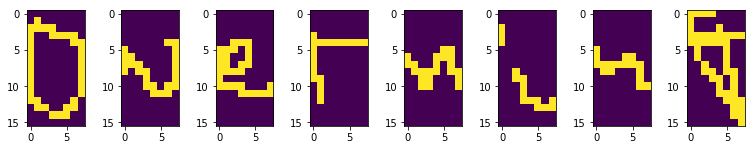

In [209]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(8,12,1)
ax1.imshow(np.int32(X_ts[14][0].reshape((16,8))))
ax2 = fig.add_subplot(8,12,2)
ax2.imshow(np.int32(X_ts[14][1].reshape((16,8))))
ax3 = fig.add_subplot(8,12,3)
ax3.imshow(np.int32(X_ts[14][2].reshape((16,8))))
ax3 = fig.add_subplot(8,12,4)
ax3.imshow(np.int32(X_ts[14][3].reshape((16,8))))
ax3 = fig.add_subplot(8,12,5)
ax3.imshow(np.int32(X_ts[14][4].reshape((16,8))))
ax3 = fig.add_subplot(8,12,6)
ax3.imshow(np.int32(X_ts[14][5].reshape((16,8))))
ax3 = fig.add_subplot(8,12,7)
ax3.imshow(np.int32(X_ts[14][6].reshape((16,8))))
ax3 = fig.add_subplot(8,12,8)
ax3.imshow(np.int32(X_ts[14][7].reshape((16,8))))

In [170]:
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [183]:
num_node = 0
for k in range(y_tr.shape[0]):
    for j in range(y_tr[k].shape[0]):
        num_node += 1
        
for k in range(y_ts.shape[0]):
    for j in range(y_ts[k].shape[0]):
        num_node += 1

X_s, y_s = np.zeros((num_node,128)), np.zeros(num_node,dtype='i4')
l = 0
for k in range(y_tr.shape[0]):
    for j in range(y_tr[k].shape[0]):
        X_s[l] = X_tr[k][j,:]
        y_s[l] = y_tr[k][j]
        l+= 1
for k in range(y_ts.shape[0]):
    for j in range(y_ts[k].shape[0]):
        X_s[l] = X_ts[k][j,:]
        y_s[l] = y_ts[k][j]
        l+= 1

In [184]:
clf_s = SVC(kernel='linear')

In [185]:
clf_s.fit(X_s,y_s)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [186]:
ham_svc = np.zeros(y_ts.shape[0])

for k in range(y_ts.shape[0]):
    ham_svc[k] = accuracy_score(y_ts[k], clf_s.predict(X_ts[k]))
    
print('SVC Avg Hamming: ', 100*ham_svc.mean(), '%')
print('SVC Zero-One loss: ', 100*ham_svc[ham_svc==1].sum()/y_ts.shape[0])

SVC Avg Hamming:  87.352387504 %
SVC Zero-One loss:  46.0059171598


In [216]:
hamm = [0.874, 0.955, 0.979]
zo = [0.460, 0.738, 0.91]
models = ['SVC', 'Unary Only', 'Unary+Binary']
met = ['Average Hamming', 'Zero-One']
res_df = pd.DataFrame(hamm)
res_df.columns = ['Average Hamming:']
res_df['Zero-One:'] = zo
res_df.columns.name = 'Model:'
res_df.index = models
res_df

Model:,Average Hamming:,Zero-One:
SVC,0.874,0.460
Unary Only,0.955,0.738
Unary+Binary,0.979,0.910


In [223]:
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

In [222]:
res_df.style.apply(highlight_max)